# Create a Siamese Network with Triplet Loss in Keras

### Item recognition 2 - using Siamese Network and Triplet Loss with Transfer Learning

Using InceptionV3

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
from utils import tbProjector, create_batch, create_testdata

In [4]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [6]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train.shape)

In [7]:
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, Activation
#from tensorflow.keras.layers import Dropout, Flatten, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [8]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [9]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [10]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 32

## See some triplets in Batch

In [11]:
def plot_triplets(examples):

    #plt.figure(figsize=(6, 6))
    fig, axs = plt.subplots(len(examples[0]), 3)
                            
    for i in range(len(examples[0])):
        
        for j in range(len(examples)):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[j, i].imshow(examples[i][j])
            plt.xticks([])
            plt.yticks([])
        #plt.title(examples[1][i])
    plt.show()

<IPython.core.display.Javascript object>


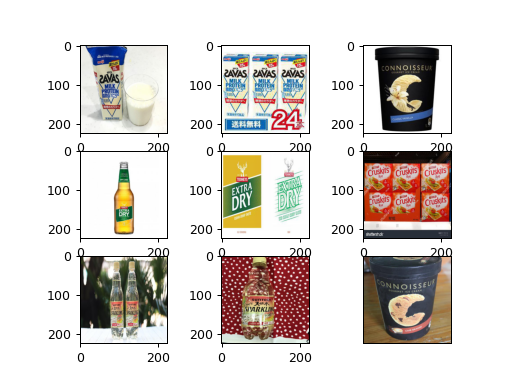

In [12]:
exp_triplet = create_batch(3)
#exp_triplet = np.squeeze(exp_triplet)
plot_triplets(exp_triplet)

## Load a pre-trained model and attach an output layer

Construct an embedding model

In [13]:
emb_size = 128

base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

img_input = keras.Input(shape=(224, 224, 3))

x = base_model(img_input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output = keras.layers.Dense(emb_size, activation='sigmoid')(x)

embedding_model = keras.Model(img_input, output)

In [14]:
embedding_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
Total params: 22,917,536
Trainable params: 1,114,752
Non-trainable params: 21,802,784
_________________________________________

In [15]:
#example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(exp_triplet)[0]

print(example_emb)

[0.23686773 0.661919   0.5595256  0.23019579 0.25408536 0.14478785
 0.6760702  0.10923746 0.45518214 0.40255827 0.2503291  0.34617895
 0.5442158  0.71274513 0.55530757 0.6202558  0.81801605 0.511848
 0.5810954  0.50531065 0.19337118 0.71055543 0.71012855 0.73548704
 0.7167167  0.56533825 0.90262467 0.72474474 0.92842996 0.32594398
 0.4575396  0.28680205 0.3097103  0.39443636 0.53061026 0.20613158
 0.3475247  0.735487   0.42206275 0.43685022 0.4394889  0.19647023
 0.47628683 0.40956995 0.6286875  0.4098351  0.35816777 0.7975657
 0.23668373 0.26492792 0.86888045 0.25039008 0.8052625  0.68406796
 0.22382134 0.5991138  0.90834206 0.2498053  0.5387533  0.8982006
 0.30534205 0.34632963 0.68037164 0.23727295 0.69108063 0.5450568
 0.3366792  0.24581552 0.06958362 0.42831323 0.49739522 0.62649477
 0.41302055 0.2507647  0.6441004  0.595318   0.51938593 0.8683509
 0.6437818  0.23793593 0.56799006 0.52617097 0.28197524 0.14012253
 0.5292312  0.53466773 0.26096985 0.40754047 0.27390918 0.62682617
 

## Create Siamese Network

In [16]:
input_anchor = tf.keras.layers.Input(shape=(224, 224, 3))
input_positive = tf.keras.layers.Input(shape=(224, 224, 3))
input_negative = tf.keras.layers.Input(shape=(224, 224, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

all_output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], all_output)
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          22917536    input_3[0][0]                    
                                                                 input_4[0][0]              

## Define Triplet Loss

**NOTE:** The following explanation came from [Coursera "Siamese Network with Triplet Loss in Keras"](https://www.coursera.org/learn/siamese-network-triplet-loss-keras/home/welcome)

---

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [17]:
#def triplet_loss(alpha, emb_dim):
#    def loss(y_true, y_pred):
#        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
#        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
#        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
#        return tf.maximum(dp - dn + alpha, 0.)
#    return loss

from utils import triplet_loss

## Define Data Generator

In [18]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size, 'train')
        y = np.zeros((batch_size, 3*emb_size))
        #print("x len = {}".format(len(x)))
        #print("x = {}".format(x))
        yield x, y

## Metrics

- `pos_mean` : Mean of anchor - positive distances (squared)
- `neg_mean` : Mean of anchor - negative distances (squared)

In [19]:
def pos_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    
    return tf.reduce_mean(positive_dist)

def neg_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    
    return tf.reduce_mean(negative_dist)

## Save test embeddings for Tensorboard

In [20]:
test_dir = os.path.join(image_dir, "test")
print(test_dir)
print("items = {}".format(len(os.listdir(test_dir))))

image_data/test
items = 89


In [21]:
all_images_test = 0
class_list_test = sorted(os.listdir(test_dir))
for i in class_list_test:
    #print(i)
    all_images_test += len(os.listdir(os.path.join(test_dir, i)))
print("All test image files = {}".format(all_images_test))
#print("class_list[:10] = {}".format(class_list[:10]))

All test image files = 1447


In [22]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [23]:
import datetime
log_dir_rel = "logs/logs-{}".format(epoch_time)
log_dir = os.path.abspath(log_dir_rel)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

## Make test data (for Tensorboard)

In [24]:
x_test = create_testdata(tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_test = np.zeros((x_test.shape[0], emb_size))
print(x_test.shape)
print(y_test.shape)

(169, 224, 224, 3)
(169, 128)


# Task 9: Model Training

In [25]:
batch_size = _BATCH_SIZE
epochs = 10
steps_per_epoch = int(all_images/batch_size)
print("step_per_epoch = {}".format(steps_per_epoch))
print("Tensorboard log_dir = {}".format(log_dir))

net.compile(loss=triplet_loss(0.2, emb_size), optimizer='adam', metrics=[
    pos_mean, neg_mean])

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[
        tbProjector(
            embedding_model,
            x_test, y_test,
            log_dir, _TB_METADATA
        )]
)

step_per_epoch = 377
Tensorboard log_dir = /home/chieko/Projects/ImageRecognition/logs/logs-1600847846
Epoch 1/10
377/377 [==============================] - 989s 3s/step - loss: 0.0897 - pos_mean: 0.1253 - neg_mean: 0.3060
Epoch 2/10
377/377 [==============================] - 995s 3s/step - loss: 0.0702 - pos_mean: 0.1498 - neg_mean: 0.3707
Epoch 3/10
377/377 [==============================] - 993s 3s/step - loss: 0.0673 - pos_mean: 0.1567 - neg_mean: 0.3834
Epoch 4/10
377/377 [==============================] - 994s 3s/step - loss: 0.0607 - pos_mean: 0.1572 - neg_mean: 0.3996
Epoch 5/10
377/377 [==============================] - 994s 3s/step - loss: 0.0598 - pos_mean: 0.1627 - neg_mean: 0.4083
Epoch 6/10
377/377 [==============================] - 993s 3s/step - loss: 0.0575 - pos_mean: 0.1627 - neg_mean: 0.4147
Epoch 7/10
377/377 [==============================] - 993s 3s/step - loss: 0.0544 - pos_mean: 0.1633 - neg_mean: 0.4155
Epoch 8/10
377/377 [==============================] - 988

In [26]:
model_filename = "siameseN_inceptionV3_" + str(epoch_time) + ".h5"

net.save(model_filename)
print("Trained model was saved into {}.".format(model_filename))

Trained model was saved into siameseN_inceptionV3_1600847846.h5.


In [27]:
embmodel_filename = "embeddings_inceptionV3_" + str(epoch_time) + ".h5"
embedding_model.save(embmodel_filename)
print("Trained model was saved into {}.".format(model_filename))

Trained model was saved into siameseN_inceptionV3_1600847846.h5.
